In [1]:
import numpy as np
import pandas as pd

# Predict Air Pollution II - predict sequences

#### Exercise objectives
- Work with sequences of different lengths
- Use RNNs to return outputs for each observation in the sequences

<hr>

This exercise is a little bit different from the previous one: Here, you **observe _only_ the weather features (not the pollution)**, and you will **predict one value of air pollution *for each observation* in the input sequence**. 

What is the use-case? 
- Let's say that you have devices that are able to measure the air pollution in some places and to relate it to some weather features. That is fine! 
- But in another place, you have only weather measurements and no way to measure the air pollution.
- Then, you will use the relation between the weather features and the air pollution in some places to be able to predict the air pollution based on the weather features in another places. 

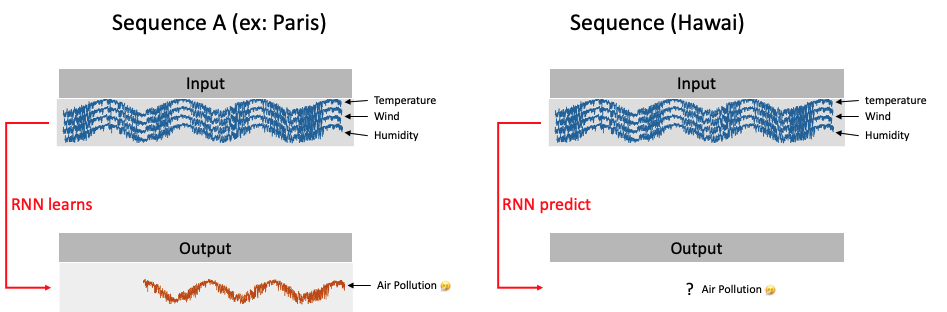

## 1. Data

👇 We load below the same dataset than in previous challenge. `pm2.5` is your target column. This time, it will not be a feature

In [64]:
df = pd.DataFrame(pd.read_csv('data.csv', index_col = 0))
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [51]:
df.describe()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [52]:
# viewing info about the columns
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 1 to 43824
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43824 non-null  int64  
 1   month   43824 non-null  int64  
 2   day     43824 non-null  int64  
 3   hour    43824 non-null  int64  
 4   pm2.5   41757 non-null  float64
 5   DEWP    43824 non-null  int64  
 6   TEMP    43824 non-null  float64
 7   PRES    43824 non-null  float64
 8   cbwd    43824 non-null  object 
 9   Iws     43824 non-null  float64
 10  Is      43824 non-null  int64  
 11  Ir      43824 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 4.3+ MB


In [53]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (43824, 12)


We separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training. And the last 20% in the test set. We also scale the data so as to have them in the same range

In [65]:
import datetime
df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: datetime.datetime(year=row['year'], month=row['month'], day=row['day'],
                                                                                          hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

In [66]:
df.index = pd.to_datetime(df['datetime'], format = '%d.%m.%Y %H:%M:%S')
df[:26]

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,datetime
datetime,,,,,,,,,,,,,
2010-01-01 00:00:00,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
2010-01-01 01:00:00,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2010-01-01 02:00:00,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
2010-01-01 03:00:00,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
2010-01-01 04:00:00,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00
2010-01-01 05:00:00,2010,1,1,5,NaN,-19,-10.0,1017.0,NW,16.10,0,0,2010-01-01 05:00:00
2010-01-01 06:00:00,2010,1,1,6,NaN,-19,-9.0,1017.0,NW,19.23,0,0,2010-01-01 06:00:00
2010-01-01 07:00:00,2010,1,1,7,NaN,-19,-9.0,1017.0,NW,21.02,0,0,2010-01-01 07:00:00
2010-01-01 08:00:00,2010,1,1,8,NaN,-19,-9.0,1017.0,NW,24.15,0,0,2010-01-01 08:00:00


In [56]:
df = df.drop(['datetime'], axis = 1)

<AxesSubplot:xlabel='datetime'>

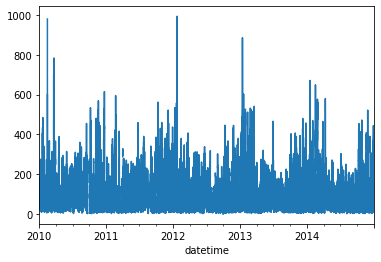

In [57]:
temp = df['pm2.5']
temp.plot()

In [58]:
# defining the size variable with 80% of length
size = int(len(df)*0.8)
size


35059

In [72]:
# subsetting and creating the training and testing data sets
# create the training set by extracting indices from 0 to 80% i.e. upto size
df_train1 = df.iloc[:size]

# create the testing set by extracting indices from 81 to 100% i.e. from size
df_test1  = df.iloc[size:]

In [67]:
# Time Serie split
import datetime
"""
splitting the dataset into train and test. The dataset's time period is from
Jan 1st, 2010 to Dec 31st, 2014. The first fours years - 2010 to 2013 is used as train(80%) and
2014(20%) is kept for validation.
"""
split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)
df_train = df.loc[df['datetime']<split_date]
df_test = df.loc[df['datetime']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_test.shape)

Shape of train: (35064, 13)
Shape of test: (8760, 13)


In [68]:
df = df.drop(['datetime', 'cbwd'], axis = 1)
df_train = df_train.drop(['datetime', 'cbwd'], axis = 1)
df_test = df_test.drop(['datetime', 'cbwd'], axis = 1)

In [69]:
# Scale with MinMaxScale
from sklearn.preprocessing import MinMaxScaler
columns = df.columns

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
0,0.0,0.0,0.0,0.000000,NaN,0.196721,0.133333,0.545455,0.002290,0.0,0.0
1,0.0,0.0,0.0,0.043478,NaN,0.196721,0.116667,0.527273,0.007639,0.0,0.0
2,0.0,0.0,0.0,0.086957,NaN,0.196721,0.133333,0.509091,0.010698,0.0,0.0
3,0.0,0.0,0.0,0.130435,NaN,0.196721,0.083333,0.509091,0.016047,0.0,0.0
4,0.0,0.0,0.0,0.173913,NaN,0.213115,0.116667,0.490909,0.021396,0.0,0.0


In [ ]:
#[[[1], [2], [3], [4], [5]]] [6]
#[[[2], [3], [4], [5], [6]]] [7]
#[[[3], [4], [5], [6], [7]]] [8]

## 2. Prepare sequences

### 2.1 Create (X,y)

Reuse your functions from previous challenge to answer this new one:

❓ **Question** ❓ Write a function `get_X_y(df, sequence_lengths)` that, given a input dataframe `df`, returns a dataset `(X, y)` where `X` are sequences of observations and `y` are their related pollution levels.

- Each observation corresponds to the weather features : TEMP, DEWP, PRES, Ir, Is, Iws. 
- If a sequence input contains `n` observations from Day `i` to Day `i+n`, then the corresponding values to predict are the sequence of pollution levels from Day `i` to Day `i+n` too.

❗ **Remark 1** In the last exercise, all the sequences had the same lengths. Here, they change with respect to the `sequence_lengths` argument, which is a list of integers:
- For instance, if `sequence_lengths = [7, 9, 6]`, $X$ will corresponds to three sequences: the first one with 7 observations, the second one with 9 observations and the third one with 6 observations.
- the length of `sequence_lengths` corresponds to the number of sequence you want to subsample from your initial sequence
- the $i$-th value of `sequence_lengths` corresponds to the length of the $i$-th sequence.

❗ **Remark 2** You are free to do whatever you want with the missing values that are in the inputs and outputs. The idea is not to spend much time on them but to get usable data.

In [70]:
# univariate data preparation
def get_X_y(df, sequence_lengths=5):
    ''' returns a dataset `(X, y)` where `X` are a list of sequences of observations, and `y` are their related pollution levels'''
    pass ### YOUR CODE HERE
    list_X = []
    list_y = []
    for i in range(sequence_lengths):
           
            list_X.append(X), list_y.append(y)
    return (np.array(list_X), np.array(list_y))


In [71]:
sequence_lengths=5
X, y = get_X_y(df, sequence_lengths)
X.shape, y.shape

((43819, 5, 1, 11), (43819, 11))

In [73]:
X_train1, y_train1 = X[:35064], y[:35064]
#X_val, y_val = X[60000:65000], y[60000:65000]
X_test1, y_test1 = X[:35064:], y[:35064:]
X_train1.shape, y_train1.shape

((35064, 5, 1, 11), (35064, 11))

👇 Test your code below

In [32]:
# Here we define the parameter to generate our train/test sets
train_size = 1000
test_size = round(0.2 * train_size)

min_seq_len = 15
max_seq_len = 30

TypeError: arg must be a list, tuple, 1-d array, or Series

In [46]:
# Let's generate some train/test sets
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [39]:
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)

In [40]:
sequence_lengths_train

array([20, 25, 22, 29, 20, 21, 25, 18, 16, 16, 18, 29, 22, 19, 27, 19, 20,
       18, 18, 19, 16, 16, 22, 23, 19, 18, 26, 15, 20, 24, 27, 24, 21, 28,
       15, 23, 22, 15, 17, 18, 24, 21, 15, 26, 23, 16, 18, 26, 17, 26, 24,
       29, 18, 17, 20, 15, 25, 15, 21, 24, 20, 15, 26, 20, 22, 19, 27, 20,
       29, 29, 23, 25, 24, 17, 21, 27, 27, 19, 28, 27, 20, 22, 17, 27, 24,
       24, 15, 29, 16, 27, 24, 24, 20, 23, 25, 26, 20, 29, 20, 19, 23, 24,
       26, 25, 27, 22, 26, 26, 17, 23, 19, 17, 28, 18, 20, 21, 16, 18, 25,
       16, 26, 17, 22, 20, 21, 23, 21, 15, 23, 23, 21, 28, 17, 27, 28, 26,
       28, 22, 17, 19, 21, 21, 17, 21, 17, 15, 23, 27, 29, 27, 20, 15, 29,
       28, 28, 17, 22, 24, 22, 21, 15, 25, 24, 25, 18, 19, 23, 17, 26, 20,
       22, 21, 25, 28, 29, 18, 25, 25, 28, 26, 28, 24, 20, 16, 27, 27, 26,
       25, 19, 15, 18, 21, 26, 26, 18, 29, 26, 23, 27, 24, 25, 21, 22, 16,
       16, 19, 26, 24, 15, 16, 28, 27, 19, 21, 25, 27, 22, 23, 18, 25, 26,
       28, 24, 20, 20, 26

In [ ]:
# Test if there are no NaN in you dataset
assert np.sum([np.isnan(x[0]).sum() for x in X_train]) == 0
assert np.sum([np.isnan(x[0]).sum() for x in X_test]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_train]) == 0
assert np.sum([np.isnan(y[0]).sum() for y in y_test]) == 0

# Check your shapes
print("X_train type", type(X_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")
print("\n")
print("y_train type", type(y_train))
print("n_sequence", len(X_train))
print("shape sequence 0", X_train[0].shape)
print("shape sequence 1", X_train[1].shape)
print("...")

☝️ It should look something like (with different sequence lenghts of course)
```
X_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...


y_train type <class 'list'>
n_sequence 1000
shape sequence 0 (27, 6)
shape sequence 1 (18, 6)
...

```

### 2.2 Padding

❓ **Question** ❓ Your input sequences have different lengths. For this reason, do not forget to pad them. For the model to work, you also need to pad your target values `y_train` and `y_test`.

You need all your sequences (train and test, X **and** y) to be of same length (not only X!). To do so, use the `maxlen=30` keyword - [see documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [ ]:
# YOUR CODE HERE

## 3. Model

❓ **Question** ❓ 
- Initialize the model of your choice here. But don't forget, you have to return a sequence of outputs!
- Do not forget to mask the padded values. You only need to do that for the inputs. Use the padded targets as normal targets, as they won't even be used for the loss computation anyway.
- Fit it and compare your prediction to a benchmark prediction

- Fine-tune your model by adjusting the different hyperparameters of by stacking different RNNs. You should be able to reach a MAE of about `0.05` on the test set

In [ ]:
def init_model():
    pass
    ### YOUR CODE HERE

❓ **Question** ❓ Plot many true sequences, as well as their predictions, to visualize your model performance

In [ ]:
# YOUR CODE HERE

🏁 **Congratulation**